In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()


def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179',\
                         'PM25_617B', 'temp', 'rh',\
                         'tgrad', 'pressure', 'pluvio']]),\
            np.array(df['PM_ref']))

        
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def dataframe_to_xy_sequences(df, sequence_size):
    out_X = np.zeros((len(df)//sequence_size, sequence_size, 8))
    out_y = np.zeros((len(df)//sequence_size, sequence_size))
    i = 0
    while i + sequence_size < len(df):
        sequence = df.iloc[i:i+sequence_size]
        out_X[i//sequence_size] =  np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']])
        out_y[i//sequence_size] = np.array(sequence['NO2_ref'])
        i += sequence_size
        
    return out_X, out_y

In [3]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, activation='relu', input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, activation='relu', input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, activation='relu', input_shape=input_dim))#input_dim=input_dim[1], input_length=input_dim[0], return_sequences=True))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


In [4]:
model = simple_rnn_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [5]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 519us/step - loss: 528.9152 - val_loss: 789.5267
Epoch 2/10000
1126/1126 [==============================] - 0s 44us/step - loss: 523.3770 - val_loss: 786.4262
Epoch 3/10000
1126/1126 [==============================] - 0s 44us/step - loss: 517.5020 - val_loss: 782.0399
Epoch 4/10000
1126/1126 [==============================] - 0s 43us/step - loss: 509.9353 - val_loss: 775.5871
Epoch 5/10000
1126/1126 [==============================] - 0s 41us/step - loss: 499.8403 - val_loss: 766.2888
Epoch 6/10000
1126/1126 [==============================] - 0s 44us/step - loss: 486.4888 - val_loss: 753.3953
Epoch 7/10000
1126/1126 [==============================] - 0s 44us/step - loss: 469.3921 - val_loss: 736.3402
Epoch 8/10000
1126/1126 [==============================] - 0s 41us/step - loss: 448.4519 - val_loss: 714.8528
Epoch 9/10000
1126/1126 [==============================] - 0s 39us/step 

Epoch 75/10000
1126/1126 [==============================] - 0s 42us/step - loss: 45.0318 - val_loss: 131.8001
Epoch 76/10000
1126/1126 [==============================] - 0s 40us/step - loss: 44.8034 - val_loss: 131.1666
Epoch 77/10000
1126/1126 [==============================] - 0s 40us/step - loss: 44.5832 - val_loss: 130.5391
Epoch 78/10000
1126/1126 [==============================] - 0s 39us/step - loss: 44.3710 - val_loss: 129.9190
Epoch 79/10000
1126/1126 [==============================] - 0s 39us/step - loss: 44.1665 - val_loss: 129.3073
Epoch 80/10000
1126/1126 [==============================] - 0s 38us/step - loss: 43.9695 - val_loss: 128.7049
Epoch 81/10000
1126/1126 [==============================] - 0s 39us/step - loss: 43.7798 - val_loss: 128.1125
Epoch 82/10000
1126/1126 [==============================] - 0s 38us/step - loss: 43.5971 - val_loss: 127.5307
Epoch 83/10000
1126/1126 [==============================] - 0s 38us/step - loss: 43.4212 - val_loss: 126.9601
Epoch 84/1

Epoch 149/10000
1126/1126 [==============================] - 0s 40us/step - loss: 38.3875 - val_loss: 110.8020
Epoch 150/10000
1126/1126 [==============================] - 0s 39us/step - loss: 38.3478 - val_loss: 110.7219
Epoch 151/10000
1126/1126 [==============================] - 0s 40us/step - loss: 38.3085 - val_loss: 110.6430
Epoch 152/10000
1126/1126 [==============================] - 0s 40us/step - loss: 38.2696 - val_loss: 110.5654
Epoch 153/10000
1126/1126 [==============================] - 0s 40us/step - loss: 38.2312 - val_loss: 110.4888
Epoch 154/10000
1126/1126 [==============================] - 0s 39us/step - loss: 38.1932 - val_loss: 110.4133
Epoch 155/10000
1126/1126 [==============================] - 0s 39us/step - loss: 38.1556 - val_loss: 110.3388
Epoch 156/10000
1126/1126 [==============================] - 0s 40us/step - loss: 38.1185 - val_loss: 110.2654
Epoch 157/10000
1126/1126 [==============================] - 0s 40us/step - loss: 38.0817 - val_loss: 110.1929
E

Epoch 223/10000
1126/1126 [==============================] - 0s 39us/step - loss: 36.2298 - val_loss: 106.9226
Epoch 224/10000
1126/1126 [==============================] - 0s 39us/step - loss: 36.2063 - val_loss: 106.8879
Epoch 225/10000
1126/1126 [==============================] - 0s 42us/step - loss: 36.1828 - val_loss: 106.8533
Epoch 226/10000
1126/1126 [==============================] - 0s 41us/step - loss: 36.1594 - val_loss: 106.8190
Epoch 227/10000
1126/1126 [==============================] - 0s 41us/step - loss: 36.1360 - val_loss: 106.7849
Epoch 228/10000
1126/1126 [==============================] - 0s 39us/step - loss: 36.1126 - val_loss: 106.7509
Epoch 229/10000
1126/1126 [==============================] - 0s 40us/step - loss: 36.0893 - val_loss: 106.7171
Epoch 230/10000
1126/1126 [==============================] - 0s 39us/step - loss: 36.0660 - val_loss: 106.6835
Epoch 231/10000
1126/1126 [==============================] - 0s 40us/step - loss: 36.0428 - val_loss: 106.6500
E

Epoch 297/10000
1126/1126 [==============================] - ETA: 0s - loss: 66.47 - 0s 40us/step - loss: 34.5178 - val_loss: 104.5894
Epoch 298/10000
1126/1126 [==============================] - 0s 40us/step - loss: 34.4942 - val_loss: 104.5595
Epoch 299/10000
1126/1126 [==============================] - 0s 40us/step - loss: 34.4706 - val_loss: 104.5297
Epoch 300/10000
1126/1126 [==============================] - 0s 41us/step - loss: 34.4469 - val_loss: 104.4999
Epoch 301/10000
1126/1126 [==============================] - 0s 42us/step - loss: 34.4232 - val_loss: 104.4703
Epoch 302/10000
1126/1126 [==============================] - 0s 42us/step - loss: 34.3995 - val_loss: 104.4407
Epoch 303/10000
1126/1126 [==============================] - 0s 40us/step - loss: 34.3757 - val_loss: 104.4113
Epoch 304/10000
1126/1126 [==============================] - 0s 40us/step - loss: 34.3518 - val_loss: 104.3820
Epoch 305/10000
1126/1126 [==============================] - 0s 42us/step - loss: 34.328

1126/1126 [==============================] - 0s 45us/step - loss: 32.5011 - val_loss: 102.9880
Epoch 371/10000
1126/1126 [==============================] - 0s 42us/step - loss: 32.4700 - val_loss: 102.9686
Epoch 372/10000
1126/1126 [==============================] - 0s 41us/step - loss: 32.4390 - val_loss: 102.9490
Epoch 373/10000
1126/1126 [==============================] - 0s 42us/step - loss: 32.4080 - val_loss: 102.9292
Epoch 374/10000
1126/1126 [==============================] - 0s 42us/step - loss: 32.3772 - val_loss: 102.9093
Epoch 375/10000
1126/1126 [==============================] - 0s 40us/step - loss: 32.3465 - val_loss: 102.8893
Epoch 376/10000
1126/1126 [==============================] - 0s 40us/step - loss: 32.3158 - val_loss: 102.8692
Epoch 377/10000
1126/1126 [==============================] - 0s 41us/step - loss: 32.2853 - val_loss: 102.8489
Epoch 378/10000
1126/1126 [==============================] - 0s 41us/step - loss: 32.2548 - val_loss: 102.8286
Epoch 379/10000
1

Epoch 444/10000
1126/1126 [==============================] - 0s 43us/step - loss: 30.4245 - val_loss: 101.5637
Epoch 445/10000
1126/1126 [==============================] - 0s 40us/step - loss: 30.3993 - val_loss: 101.5454
Epoch 446/10000
1126/1126 [==============================] - 0s 40us/step - loss: 30.3742 - val_loss: 101.5272
Epoch 447/10000
1126/1126 [==============================] - 0s 43us/step - loss: 30.3492 - val_loss: 101.5089
Epoch 448/10000
1126/1126 [==============================] - 0s 41us/step - loss: 30.3243 - val_loss: 101.4907
Epoch 449/10000
1126/1126 [==============================] - 0s 40us/step - loss: 30.2994 - val_loss: 101.4726
Epoch 450/10000
1126/1126 [==============================] - 0s 43us/step - loss: 30.2746 - val_loss: 101.4544
Epoch 451/10000
1126/1126 [==============================] - 0s 41us/step - loss: 30.2499 - val_loss: 101.4363
Epoch 452/10000
1126/1126 [==============================] - 0s 39us/step - loss: 30.2252 - val_loss: 101.4183
E

Epoch 518/10000
1126/1126 [==============================] - 0s 53us/step - loss: 28.7012 - val_loss: 100.4110
Epoch 519/10000
1126/1126 [==============================] - 0s 48us/step - loss: 28.6785 - val_loss: 100.4003
Epoch 520/10000
1126/1126 [==============================] - 0s 47us/step - loss: 28.6558 - val_loss: 100.3898
Epoch 521/10000
1126/1126 [==============================] - 0s 46us/step - loss: 28.6331 - val_loss: 100.3796
Epoch 522/10000
1126/1126 [==============================] - 0s 50us/step - loss: 28.6104 - val_loss: 100.3696
Epoch 523/10000
1126/1126 [==============================] - 0s 47us/step - loss: 28.5876 - val_loss: 100.3599
Epoch 524/10000
1126/1126 [==============================] - 0s 41us/step - loss: 28.5649 - val_loss: 100.3504
Epoch 525/10000
1126/1126 [==============================] - 0s 40us/step - loss: 28.5421 - val_loss: 100.3412
Epoch 526/10000
1126/1126 [==============================] - 0s 40us/step - loss: 28.5193 - val_loss: 100.3322
E

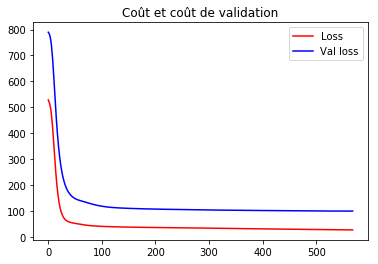

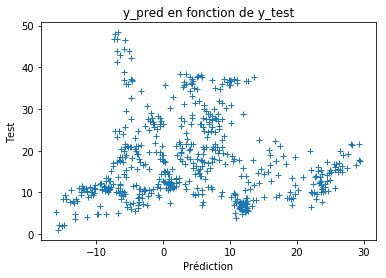

In [6]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [7]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5632      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 892us/step - loss: 529.0126 - val_loss: 789.5127
Epoch 2/10000
1126/1126 [==============================] - 0s 74us/step - loss: 525.7961 - val_loss: 785.3983
Epoch 3/10000
1126/1126 [==============================] - 0s 73us/step - loss: 521.2918 - val_loss: 778.9629
Epoch 4/10000
1126/1126 [==============================] - 0s 65us/step - loss: 514.0987 - val_loss: 768.7310
Epoch 5/10000
1126/1126 [==============================] - 0s 68us/step - loss: 503.1723 - val_loss: 753.9765
Epoch 6/10000
1126/1126 [==============================] - 0s 65us/step - loss: 488.3414 - val_loss: 735.1484
Epoch 7/10000
1126/1126 [==============================] - 0s 65us/step - loss: 470.3011 - val_loss: 713.2950
Epoch 8/10000
1126/1126 [==============================] - 0s 66us/step - loss: 450.1946 - val_loss: 689.6009
Epoch 9/10000
1126/1126 [==============================] - 0s 69us/step 

Epoch 75/10000
1126/1126 [==============================] - 0s 66us/step - loss: 46.9433 - val_loss: 158.8963
Epoch 76/10000
1126/1126 [==============================] - 0s 65us/step - loss: 46.6876 - val_loss: 158.1885
Epoch 77/10000
1126/1126 [==============================] - 0s 66us/step - loss: 46.4357 - val_loss: 157.4860
Epoch 78/10000
1126/1126 [==============================] - 0s 69us/step - loss: 46.1875 - val_loss: 156.7880
Epoch 79/10000
1126/1126 [==============================] - 0s 70us/step - loss: 45.9434 - val_loss: 156.0910
Epoch 80/10000
1126/1126 [==============================] - 0s 67us/step - loss: 45.7064 - val_loss: 155.3847
Epoch 81/10000
1126/1126 [==============================] - 0s 67us/step - loss: 45.4773 - val_loss: 154.6587
Epoch 82/10000
1126/1126 [==============================] - 0s 65us/step - loss: 45.2544 - val_loss: 153.9327
Epoch 83/10000
1126/1126 [==============================] - 0s 67us/step - loss: 45.0379 - val_loss: 153.2163
Epoch 84/1

1126/1126 [==============================] - 0s 65us/step - loss: 36.8899 - val_loss: 123.3617
Epoch 150/10000
1126/1126 [==============================] - 0s 66us/step - loss: 36.8189 - val_loss: 123.1460
Epoch 151/10000
1126/1126 [==============================] - 0s 68us/step - loss: 36.7483 - val_loss: 122.9370
Epoch 152/10000
1126/1126 [==============================] - 0s 67us/step - loss: 36.6790 - val_loss: 122.7284
Epoch 153/10000
1126/1126 [==============================] - 0s 72us/step - loss: 36.6106 - val_loss: 122.5249
Epoch 154/10000
1126/1126 [==============================] - 0s 63us/step - loss: 36.5425 - val_loss: 122.3227
Epoch 155/10000
1126/1126 [==============================] - 0s 66us/step - loss: 36.4757 - val_loss: 122.1174
Epoch 156/10000
1126/1126 [==============================] - 0s 66us/step - loss: 36.4093 - val_loss: 121.9274
Epoch 157/10000
1126/1126 [==============================] - 0s 68us/step - loss: 36.3438 - val_loss: 121.7386
Epoch 158/10000
1

Epoch 223/10000
1126/1126 [==============================] - 0s 69us/step - loss: 32.7685 - val_loss: 115.8275
Epoch 224/10000
1126/1126 [==============================] - 0s 72us/step - loss: 32.7183 - val_loss: 115.8092
Epoch 225/10000
1126/1126 [==============================] - 0s 66us/step - loss: 32.6680 - val_loss: 115.7891
Epoch 226/10000
1126/1126 [==============================] - 0s 64us/step - loss: 32.6179 - val_loss: 115.7751
Epoch 227/10000
1126/1126 [==============================] - 0s 75us/step - loss: 32.5672 - val_loss: 115.7580
Epoch 228/10000
1126/1126 [==============================] - 0s 63us/step - loss: 32.5169 - val_loss: 115.7453
Epoch 229/10000
1126/1126 [==============================] - 0s 65us/step - loss: 32.4664 - val_loss: 115.7362
Epoch 230/10000
1126/1126 [==============================] - 0s 65us/step - loss: 32.4158 - val_loss: 115.7251
Epoch 231/10000
1126/1126 [==============================] - 0s 64us/step - loss: 32.3652 - val_loss: 115.7149
E

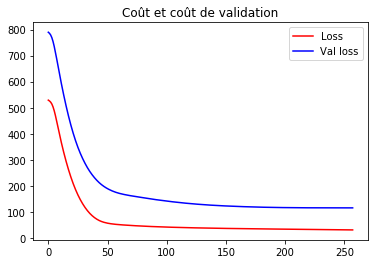

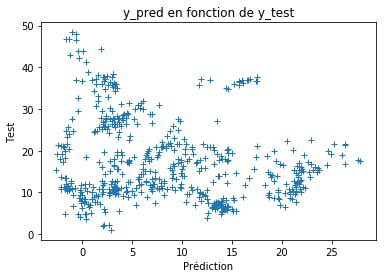

In [9]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 755us/step - loss: 529.1473 - val_loss: 788.8348
Epoch 2/10000
1126/1126 [==============================] - 0s 63us/step - loss: 525.4269 - val_loss: 784.6237
Epoch 3/10000
1126/1126 [==============================] - 0s 64us/step - loss: 520.6984 - val_loss: 778.6225
Epoch 4/10000
1126/1126 [==============================] - 0s 63us/step - loss: 513.5087 - val_loss: 769.3862
Epoch 5/10000
1126/1126 [==============================] - 0s 64us/step - loss: 502.4514 - val_loss: 755.4194
Epoch 6/10000
1126/1126 [==============================] - 0s 64us/step - loss: 486.5924 - val_loss: 736.1571
Epoch 7/10000
1126/1126 [==============================] - 0s 59us/step - loss: 466.1212 - val_loss: 712.2956
Epoch 8/10000
1126/1126 [==============================] - 0s 61us/step - loss: 442.1940 - val_loss: 685.2072
Epoch 9/10000
1126/1126 [==============================] - 0s 61us/step 

Epoch 75/10000
1126/1126 [==============================] - 0s 76us/step - loss: 43.4681 - val_loss: 143.3295
Epoch 76/10000
1126/1126 [==============================] - 0s 79us/step - loss: 43.2874 - val_loss: 142.7154
Epoch 77/10000
1126/1126 [==============================] - 0s 82us/step - loss: 43.1092 - val_loss: 142.1014
Epoch 78/10000
1126/1126 [==============================] - 0s 96us/step - loss: 42.9339 - val_loss: 141.4998
Epoch 79/10000
1126/1126 [==============================] - 0s 80us/step - loss: 42.7607 - val_loss: 140.9011
Epoch 80/10000
1126/1126 [==============================] - 0s 65us/step - loss: 42.5903 - val_loss: 140.2915
Epoch 81/10000
1126/1126 [==============================] - 0s 65us/step - loss: 42.4227 - val_loss: 139.6818
Epoch 82/10000
1126/1126 [==============================] - 0s 61us/step - loss: 42.2587 - val_loss: 139.0728
Epoch 83/10000
1126/1126 [==============================] - 0s 62us/step - loss: 42.0983 - val_loss: 138.4679
Epoch 84/1

1126/1126 [==============================] - 0s 67us/step - loss: 36.1323 - val_loss: 115.8629
Epoch 150/10000
1126/1126 [==============================] - 0s 61us/step - loss: 36.0835 - val_loss: 115.7343
Epoch 151/10000
1126/1126 [==============================] - 0s 61us/step - loss: 36.0346 - val_loss: 115.6060
Epoch 152/10000
1126/1126 [==============================] - 0s 56us/step - loss: 35.9866 - val_loss: 115.4783
Epoch 153/10000
1126/1126 [==============================] - 0s 61us/step - loss: 35.9389 - val_loss: 115.3632
Epoch 154/10000
1126/1126 [==============================] - 0s 62us/step - loss: 35.8912 - val_loss: 115.2500
Epoch 155/10000
1126/1126 [==============================] - 0s 65us/step - loss: 35.8440 - val_loss: 115.1321
Epoch 156/10000
1126/1126 [==============================] - 0s 64us/step - loss: 35.7972 - val_loss: 115.0250
Epoch 157/10000
1126/1126 [==============================] - 0s 66us/step - loss: 35.7505 - val_loss: 114.9205
Epoch 158/10000
1

Epoch 223/10000
1126/1126 [==============================] - 0s 57us/step - loss: 33.0560 - val_loss: 111.7040
Epoch 224/10000
1126/1126 [==============================] - 0s 56us/step - loss: 33.0179 - val_loss: 111.6994
Epoch 225/10000
1126/1126 [==============================] - 0s 56us/step - loss: 32.9802 - val_loss: 111.6953
Epoch 226/10000
1126/1126 [==============================] - 0s 57us/step - loss: 32.9426 - val_loss: 111.6918
Epoch 227/10000
1126/1126 [==============================] - 0s 55us/step - loss: 32.9048 - val_loss: 111.6918
Epoch 228/10000
1126/1126 [==============================] - 0s 56us/step - loss: 32.8667 - val_loss: 111.6899
Epoch 229/10000
1126/1126 [==============================] - 0s 55us/step - loss: 32.8289 - val_loss: 111.6879
Epoch 230/10000
1126/1126 [==============================] - 0s 57us/step - loss: 32.7909 - val_loss: 111.6844
Epoch 231/10000
1126/1126 [==============================] - 0s 56us/step - loss: 32.7533 - val_loss: 111.6826
E

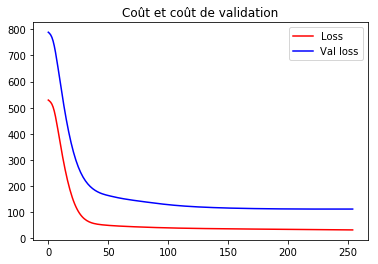

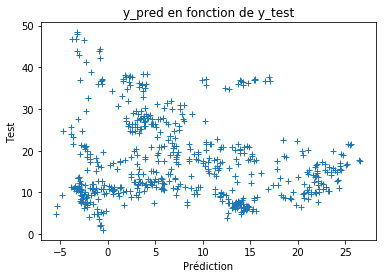

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()